# Extending Transmission Line Models to Second-Harmonic Nonlinear Electrochemical Impedance Spectra 

### Yuefan Ji and Daniel T. Schwartz<br>*Department of Chemical Engineering & Clean Energy Institute,<br>University of Washington*

# Supplementary Notebook 

## List of Figures

### - [Figure 3. Convergence Criterion for nTLM](#Figure-3.-Convergence-Criterion-for-nTLM)
### - [Figure 4. Linear Current Distribution](#Figure-4.-Linear-Current-Distribution)
### - [Figure 5. Simulated 2-RC core-shell and 1-RC equivalent TLM/2nd-nTLM](#Figure-5.-Simulated-2-RC-core-shell-and-1-RC-equivalent-TLM2nd-nTLM)
### - [Figure 6. Curve fitting results with 2-RC TLM/nTLM model as experimental data](#Figure-6.-Curve-fitting-results-with-2-RC-TLMnTLM-model-as-experimental-data)

<!-- ### - [Figure 5. Validation Results with Weakly Nonlinear Porous Electrode](#Figure-5.)
### - [Figure 6. Kramers-Kronig Test for Extracted EIS and 2nd-NLEIS (18650 Cell)](#Figure-6.)
### - [Figure 7. Measurement Model Test for 18650 Cell Collected with 0.3, 0.4, 0.5 A Perturbation (cost method)](#Figure-7.)
### - [Figure 8. Measurement Model Test for Pouch Cell Replicates (cost method)](#Figure-8.)
### - [Figure 9. Kramers-Kronig Test for EIS and 2nd-NLEIS (In-house Coin Cell)](#Figure-9.) -->

## Load Essential Packages

In [1]:
## editing system path to enable the load of nleis.py
import os.path
import sys
current_dir = os.path.dirname(os.path.abspath('__file__'))

# Get the parent directory by moving up one level
parent_dir = os.path.dirname(current_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

In [2]:
##### basic package
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from tabulate import tabulate

import time
import string

##### import impedance.py and nleis.py
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist
from nleis import NLEISCustomCircuit, EISandNLEIS
from nleis.visualization import plot_first,plot_second

##### ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
def R2 (Zdata, Zmodel):
    """
    Calculate the R2 value between the impedance data and model.
    
    Parameters:
    Zdata : array-like
        The measured impedance data.
    Zmodel : array-like
        The predicted impedance model values.
        
    Returns:
    float
        The R2 value.
    """
    Zdata_stack = np.hstack([Zdata.real, Zdata.imag])
    Zmodel_stack = np.hstack([Zmodel.real, Zmodel.imag])
    residuals = Zdata_stack - Zmodel_stack
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((Zdata_stack - np.mean(Zdata_stack))**2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [4]:
def mae(Zdata, Zmodel):
    """
    Calculate the Mean Absolute Error (MAE) between the impedance data and model.
    
    Parameters:
    Zdata : array-like
        The measured impedance data.
    Zmodel : array-like
        The predicted impedance model values.
        
    Returns:
    float
        The MAE value.
    """
    Zdata_stack = np.hstack([Zdata.real, Zdata.imag])
    Zmodel_stack = np.hstack([Zmodel.real, Zmodel.imag])
    mae_value = np.mean(np.abs(Zdata_stack - Zmodel_stack))
    return mae_value

In [5]:
def arrow(ax,x1,y1,x2,y2,x3,y3,connectionstyle):
    # Draw an arrow on the plot with a label at the end.
    # Parameters:
    # - ax: The axes on which to draw the arrow.
    # - x1, y1: The ending point of the arrow. 
    # - x2, y2: The starting point of the arrow.
    # - x3, y3: The position of the label.
    # - connectionstyle: The style of the arrow connection.

    ax.annotate("",
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->", color='k',lw=3,
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle=connectionstyle,
                                ),
                )
    ax.text(x3,y3,'ω',size=18,weight='bold')
    return()

In [6]:
# Define the frequency for simulation
f = np.geomspace(1e-3, 1e4, 100, endpoint=True)  # frequency range from 1e-3 Hz to 1e4 Hz

## Figure 3. Convergence Criterion for nTLM

0.1
The time required to calculate EIS and 2nd-NLEIS for a 1 elements TLM with Rpore/Rct = 0.1 is
--- 0 mins 0.01 seconds ---
The time required to calculate EIS and 2nd-NLEIS for a 10 elements TLM with Rpore/Rct = 0.1 is
--- 0 mins 0.02 seconds ---
The time required to calculate EIS and 2nd-NLEIS for a 100 elements TLM with Rpore/Rct = 0.1 is
--- 0 mins 2.01 seconds ---
The time required to calculate EIS and 2nd-NLEIS for a 1000 elements TLM with Rpore/Rct = 0.1 is
--- 0 mins 27.54 seconds ---
1.0
The time required to calculate EIS and 2nd-NLEIS for a 1 elements TLM with Rpore/Rct = 1.0 is
--- 0 mins 0.01 seconds ---
The time required to calculate EIS and 2nd-NLEIS for a 10 elements TLM with Rpore/Rct = 1.0 is
--- 0 mins 0.02 seconds ---
The time required to calculate EIS and 2nd-NLEIS for a 100 elements TLM with Rpore/Rct = 1.0 is
--- 0 mins 0.33 seconds ---
The time required to calculate EIS and 2nd-NLEIS for a 1000 elements TLM with Rpore/Rct = 1.0 is
--- 0 mins 28.05 seconds ---
10

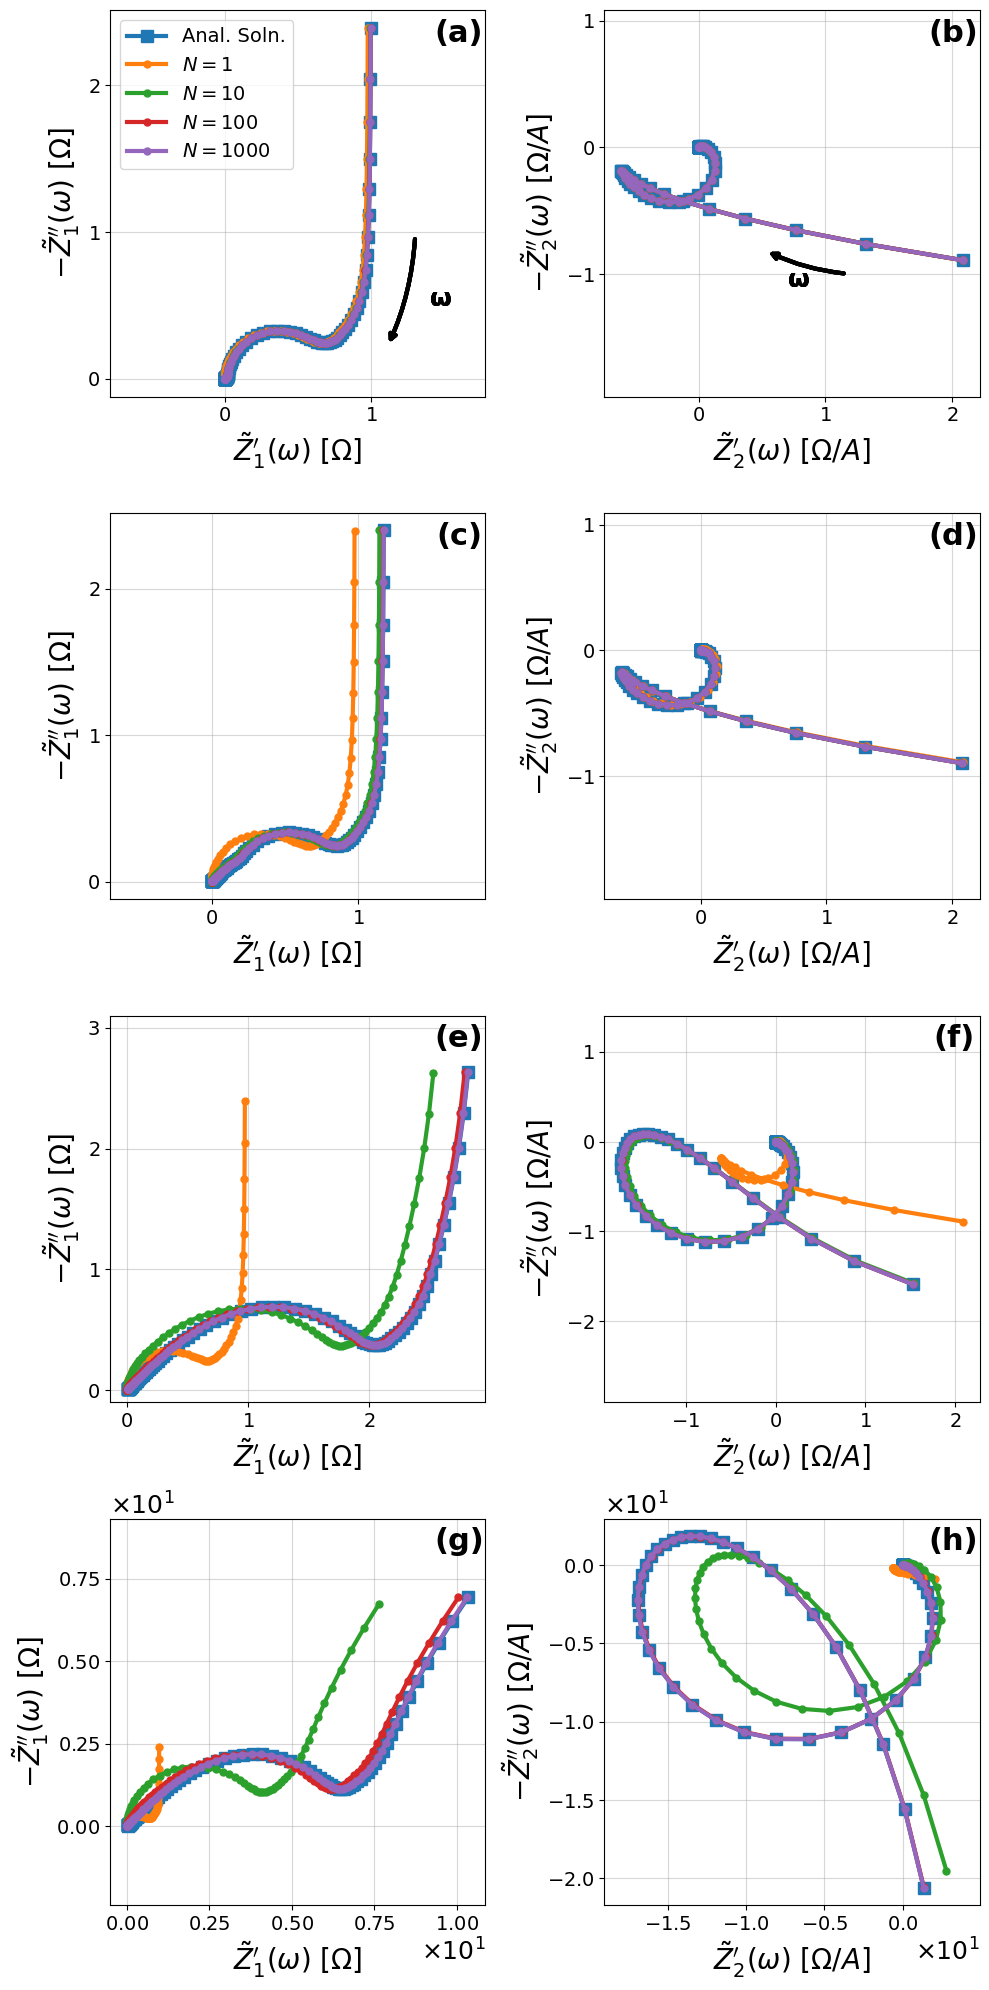

In [7]:
max_N = 4

fig, ax = plt.subplots(max_N,2,figsize=(5*2,max_N*5))#12:6

## Acutal Parameters that are affecting the response
Rpore_raw = .06 # Ohms
Rct = 0.6 # Ohms
Cdl = 0.72 # F
Aw = 2 # Ohms
tau = 400 # s
k = -1 # V^-1
eb = 0.1

## Dummy Parameters that are not affecting the response
## Setting the second RC to zero
Rs = 0 # Ohms
Cs = .72 # F
es = 0

## Calculation time
cal_time = np.zeros([max_N,max_N])

for i in range (0,max_N):
    
    Rpore = Rpore_raw*10**i
    print(Rpore/Rct)
    
    ## Calculating the analytical solution for the EIS 
    constants ={'TDS0_0':Rpore,'TDS0_1':Rct,'TDS0_2':Cdl,'TDS0_3':Aw,'TDS0_4':tau}
    circuit_1 = CustomCircuit('TDS0', constants=constants)
    Z1 = circuit_1.predict(f)

    ## Calculating the analytical solution for the 2nd-NTLM 
    constants={'TDSn0_0':Rpore,'TDSn0_1':Rct,'TDSn0_2':Cdl,'TDSn0_3':Aw,'TDSn0_4':tau,'TDSn0_5':k,'TDSn0_6':eb}
    circuit_2 = NLEISCustomCircuit('TDSn0',constants = constants )
    Z2 = circuit_2.predict(f)

    ## Plotting the EIS and 2nd-NLEIS for analytical solution
    plot_first(ax[i,0],Z1, fmt='-s',lw=3,ms =8,alpha=1,label = 'Anal. Soln.')
    plot_second(ax[i,1], Z2, fmt='-s',lw=3,ms =8, alpha=1,label = 'Anal. Soln.')
    
    ## perform TLM/2nd-nTLM calculations for different N
    for j in range (0,max_N):

        start_time = time.time()
    
        N =10**j

        ## Calculating the TLM
        circ_str_1 = 'R0-TLMS0'
        constants = {'R0':0,'TLMS0_0':Rpore,'TLMS0_1':Rct,'TLMS0_2':Cdl
                      ,'TLMS0_3':Aw,'TLMS0_4':tau,'TLMS0_5':Rs,'TLMS0_6':Cs,'TLMS0_7':N}
        circuit_1 = CustomCircuit(circ_str_1, constants=constants)
        Z1_TLM = circuit_1.predict(f)
        
        ## Calculating the 2nd-nTLM
        circ_str_2 = 'R0-TLMSn0'
        constants = {'R0':0,'TLMSn0_0':Rpore,'TLMSn0_1':Rct,'TLMSn0_2':Cdl
                      ,'TLMSn0_3':Aw,'TLMSn0_4':tau,'TLMSn0_5':Rs,'TLMSn0_6':Cs,'TLMSn0_7':N
                      ,'TLMSn0_8':k,'TLMSn0_9':eb,'TLMSn0_10':es}
        
        circuit_2 = NLEISCustomCircuit(circ_str_2, constants=constants)
        Z2_TLM = circuit_2.predict(f)
    
        ## Plotting the EIS and 2nd-NLEIS for TLM and 2nd-nTLM
        plot_first(ax[i,0],Z1_TLM, fmt='-o',lw=3,ms =5,alpha=1,color='C'+str(j+1),label=r"$ N = "+str(N)+"$")
        plot_second(ax[i,1], Z2_TLM, fmt='-o',lw=3,ms=5,alpha=1,color='C'+str(j+1), label=r"$ N = "+str(N)+"$")
        
        ax[0,0].legend(fontsize=14)
        total_time = time.time() - start_time
        cal_time[i,j]=total_time
        
        print('The time required to calculate EIS and 2nd-NLEIS for a '+ str(N) +' elements TLM with Rpore/Rct = ' + str(Rpore/Rct)+' is')
        print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))
    if i == 2:
        ax[i,0].set_ylim([-0.5,3.5])
    ax[i,0].text(0.93, 0.94, '('+string.ascii_lowercase[2*i]+')',horizontalalignment='center',verticalalignment='center', transform=ax[i,0].transAxes, size=22, weight='bold')
    ax[i,1].text(0.93, 0.94, '('+string.ascii_lowercase[2*i+1]+')',horizontalalignment='center',verticalalignment='center', transform=ax[i,1].transAxes, size=22, weight='bold')
    arrow(ax[0,0], 1.1, 0.2, 1.3, 1, 1.4, 0.5, connectionstyle="arc3,rad=-.1")
    arrow(ax[0,1], 0.5, -0.8, 1.2, -1, 0.7, -1.1, connectionstyle="arc3,rad=-.1")

plt.tight_layout()
plt.show()

In [8]:
fig.savefig('figures/Figure3.png',dpi=300,bbox_inches='tight')

### Calculation time for nTLM

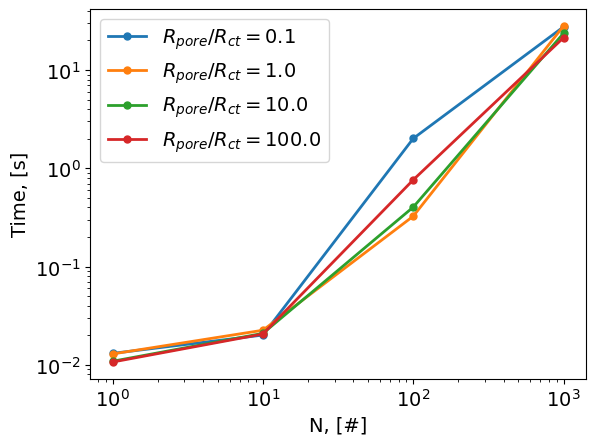

In [9]:
x = np.linspace(0,max_N-1,max_N)
N = 10**x
ratio = 10**(x-1)

for k in range (0,max_N):
    plt.loglog(N,cal_time[k,:],'-o', lw = 2, ms = 5, label=r"$ R_{pore}/R_{ct} = " + str(ratio[k]) + "$")

plt.xlabel('N, [#]', fontsize=14)
plt.ylabel('Time, [s]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Figure 4. Linear Current Distribution

In [10]:
fontsize = 16

In [11]:
Rpore = 0.1
Rct = 1
Cdl = 1

circuit_1 = NLEISCustomCircuit('TP',initial_guess = [Rpore, Rct, Cdl])
Z1 = circuit_1.predict(f,max_f=np.inf)

circuit_1 = NLEISCustomCircuit('mTi',initial_guess = [Rpore, Rct, Cdl,0,1,100])
I1 = circuit_1.predict(f,max_f=np.inf)

Rpore = 1
Rct = 1
Cdl = 1

circuit_1 = NLEISCustomCircuit('TP',initial_guess = [Rpore, Rct, Cdl])
Z2 = circuit_1.predict(f,max_f=np.inf)

circuit_1 = NLEISCustomCircuit('mTi',initial_guess = [Rpore, Rct, Cdl,0,1,100])
I2 = circuit_1.predict(f,max_f=np.inf)

Rpore = 10
Rct = 1
Cdl = 1

circuit_1 = NLEISCustomCircuit('TP',initial_guess = [Rpore, Rct, Cdl])
Z3 = circuit_1.predict(f,max_f=np.inf)

circuit_1 = NLEISCustomCircuit('mTi',initial_guess = [Rpore, Rct, Cdl,0,1,100])
I3 = circuit_1.predict(f,max_f=np.inf)

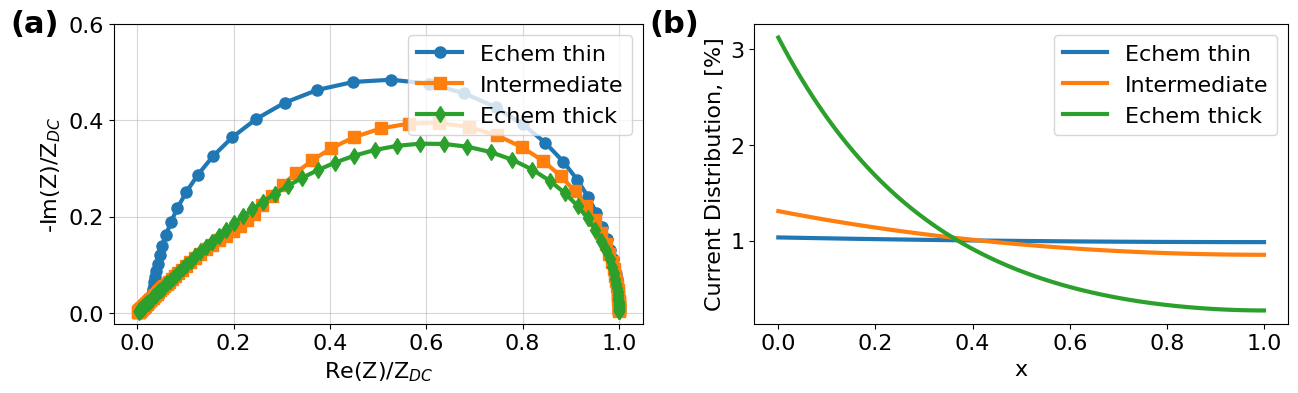

In [12]:
import string
fig, ax = plt.subplots(1,2, figsize=(13,4))
for idx, axi in enumerate(ax.flat):    
    axi.text(-0.15, 1, f'({string.ascii_lowercase[idx]})',horizontalalignment='center',verticalalignment='center', transform=axi.transAxes, size=22, weight='bold')

# plot_nyquist(Z1/Z1.real.max(), ax = ax[0], lw = 3, ms = 8, fmt='-o')
# plot_nyquist(Z2/Z2.real.max(), ax = ax[0], lw = 3, ms = 8, fmt='-o')
# plot_nyquist(Z3/Z3.real.max(), ax = ax[0], lw = 3, ms = 8, fmt='-o')
plot_nyquist(Z1/Z1.real.max(), ax = ax[0], lw = 3, ms = 8, fmt='-o')
plot_nyquist(Z2/Z2.real.max(), ax = ax[0], lw = 3, ms = 8, fmt='-s')
plot_nyquist(Z3/Z3.real.max(), ax = ax[0], lw = 3, ms = 8, fmt='-d')

ax[0].set_xlabel('Re(Z)/Z$_{DC}$', fontsize=fontsize)
ax[0].set_ylabel('-Im(Z)/Z$_{DC}$', fontsize=fontsize)
ax[0].set_xticks([0,0.2,0.4,0.6, 0.8, 1])
ax[0].set_yticks([0,0.2,0.4,0.6])

ax[0].tick_params(axis='both', labelsize=fontsize)
ax[0].legend(['Echem thin','Intermediate','Echem thick'],fontsize=fontsize, loc='upper right')

x = np.linspace(0,1,100)
ax[1].plot(x,abs(I1[0])*100,lw = 3)
ax[1].plot(x,abs(I2[0])*100,lw = 3)
ax[1].plot(x,abs(I3[0])*100,lw = 3)
ax[1].legend(['Echem thin','Intermediate','Echem thick'],fontsize=fontsize)
ax[1].tick_params(axis='both', labelsize=fontsize)

ax[1].set_xlabel('x',fontsize=fontsize)
ax[1].set_ylabel('Current Distribution, [%]',fontsize=fontsize)
plt.tight_layout()
plt.show()

In [13]:
fig.savefig('figures/Figure4.png',dpi=300,bbox_inches='tight')

## Figure 5. Simulated 2-RC core-shell and 1-RC equivalent TLM/2nd-nTLM

In [14]:
def wrapper_function(p,f,ax1,ax2,N):
    Rpore = p[0] # Ohms
    Rct = p[1] # Ohms
    Cdl = p[2] # F
    Aw = p[3] # Ohms
    tau = p[4] #s
    Rs = p[5] # Ohms
    Cs = p[6] # F
    k = p[7] # V^-1
    eb = p[8] # [-]
    es = p[9] # [-]
    
    ## Performing the TLM calculation
    circ_str_1 = 'TLMS0'
    constants = {'TLMS0_0':Rpore,'TLMS0_1':Rct,'TLMS0_2':Cdl
                  ,'TLMS0_3':Aw,'TLMS0_4':tau,'TLMS0_5':Rs,'TLMS0_6':Cs,'TLMS0_7':N}
    circuit_1 = CustomCircuit(circ_str_1, constants=constants)
    Z1_TLM = circuit_1.predict(f)

    ## Performing the 2nd-nTLM calculation
    circ_str_2 = 'TLMSn0'
    constants = {'TLMSn0_0':Rpore,'TLMSn0_1':Rct,'TLMSn0_2':Cdl
                  ,'TLMSn0_3':Aw,'TLMSn0_4':tau,'TLMSn0_5':Rs,'TLMSn0_6':Cs,'TLMSn0_7':N
                  ,'TLMSn0_8':k,'TLMSn0_9':eb,'TLMSn0_10':es}
    
    circuit_2 = NLEISCustomCircuit(circ_str_2, constants=constants)
    Z2_TLM = circuit_2.predict(f)

    ## Plotting the EIS and 2nd-NLEIS for TLM and 2nd-nTLM
    plot_first(ax1,Z1_TLM, fmt='-o',lw=3,ms =5,alpha=1)
    plot_second(ax2, Z2_TLM, fmt='-o',lw=3,ms=5,alpha=1)
    
    return (Z1_TLM,Z2_TLM)

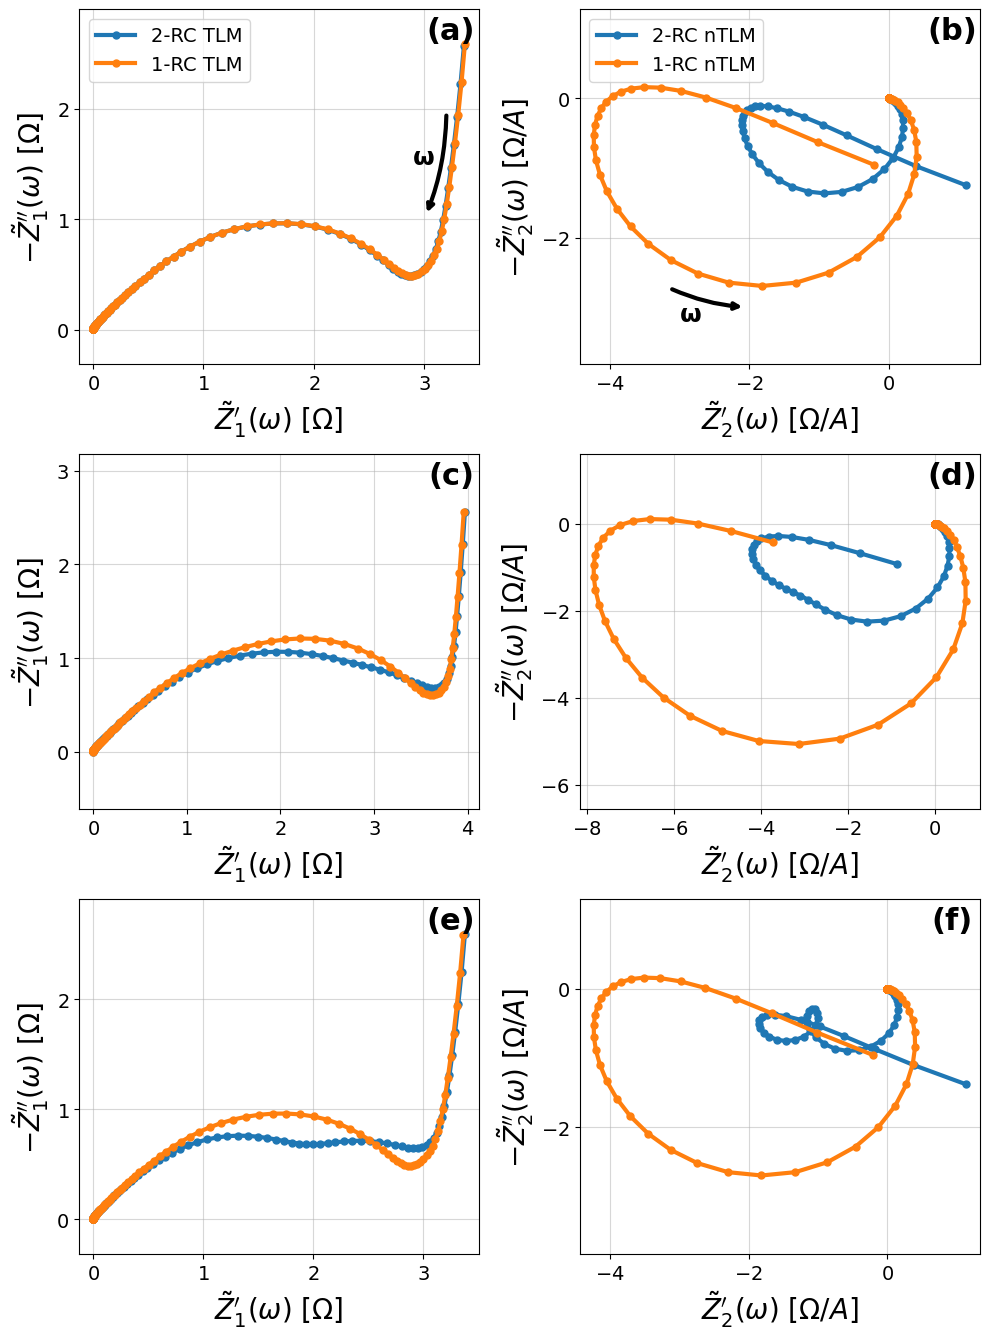

In [15]:
fig, ax = plt.subplots(3,2,figsize=(10,13.5))

N=100
#### Case 1: same charge transfer resistance and time constant between bulk and surface layer
#### One-RC TLM possesses same time time constant as two-RC TLM 
#### and same equivalent charge transfer resistance

## Two-RC TLM ##

Rpore = 6;Rct = 0.6;Cdl = 2*0.72;Aw = 2;tau = 400
Rs = 0.6;Cs = 2*0.72;k = -1;eb = 0.1;es = 0.1
p = [Rpore, Rct, Cdl, Aw, tau, Rs, Cs, k, eb, es]
Z_2RC_case1 = wrapper_function(p,f,ax[0,0],ax[0,1],N)

## One-RC TLM ##
Rpore = 6;Rct = 0.6*2;Cdl = 0.72;Aw = 2;tau = 400
Rs = 0;Cs = 0;k = -1;eb = 0.1;es = 0
p = [Rpore, Rct, Cdl, Aw, tau, Rs, Cs, k, eb, es]
Z_1RC_case1 = wrapper_function(p,f,ax[0,0],ax[0,1],N)

#### Case 2: different time constant between bulk and surface layer: 
#### Bulk charge transfer resistance is 2 times larger than surface
#### One-RC TLM possesses same equivalent charge transfer resistance as Two-RC TLM，but different time constant 

## Two-RC TLM ##
Rpore = 6;Rct = .6*2;Cdl = .72;Aw = 2;tau = 400
Rs = 0.6;Cs = 7.2;k = -1;eb = 0.1;es = 0.1
p = [Rpore, Rct, Cdl, Aw, tau, Rs, Cs, k, eb, es]
Z_2RC_case2 = wrapper_function(p,f,ax[1,0],ax[1,1],N)

## One-RC TLM##
Rpore = 6;Rct = 0.6*3;Cdl = 0.72;Aw = 2;tau = 400
Rs = 0;Cs = 0;k = -1;eb = 0.1;es = 0
p = [Rpore, Rct, Cdl, Aw, tau, Rs, Cs, k, eb, es]
Z_1RC_case2 = wrapper_function(p,f,ax[1,0],ax[1,1],N)


#### Case 3: same charge transfer resistance, but different time constant between bulk and surface layer
#### One-RC TLM possesses different time constant as two-RC TLM 
#### and same equivalent charge transfer resistance

## Two-RC TLM ##

Rpore = 6;Rct = 0.6;Cdl = 0.72;Aw = 2;tau = 400
Rs = 0.6;Cs = 7.2;k = -1;eb = 0.1;es = 0.1
p = [Rpore, Rct, Cdl, Aw, tau, Rs, Cs, k, eb, es]
Z_2RC_case3 = wrapper_function(p,f,ax[2,0],ax[2,1],N)

## One-RC TLM ##
Rpore = 6;Rct = 0.6*2;Cdl = 0.72;Aw = 2;tau = 400
Rs = 0;Cs = 0;k = -1;eb = 0.1;es = 0
p = [Rpore, Rct, Cdl, Aw, tau, Rs, Cs, k, eb, es]
Z_1RC_case3 = wrapper_function(p,f,ax[2,0],ax[2,1],N)


## add legend
ax[0,0].legend(['2-RC TLM','1-RC TLM'],fontsize =14)
ax[0,1].legend(['2-RC nTLM','1-RC nTLM',],fontsize =14,loc='upper left')

for idx, axi in enumerate(ax.flat):    
    axi.text(0.93, 0.94, f'({string.ascii_lowercase[idx]})',horizontalalignment='center',verticalalignment='center', transform=axi.transAxes, size=22, weight='bold')
arrow(ax[0,0], 3, 1, 3.2, 2, 2.9, 1.5, connectionstyle="arc3,rad=-.1")
arrow(ax[0,1], -2, -3, -3.2, -2.7, -3, -3.2, connectionstyle="arc3,rad=.1")
plt.tight_layout()
plt.show()

In [16]:
fig.savefig('figures/Figure5.png',dpi=300,bbox_inches='tight')

## Figure 6. Curve fitting results with 2-RC TLM/nTLM model as experimental data 

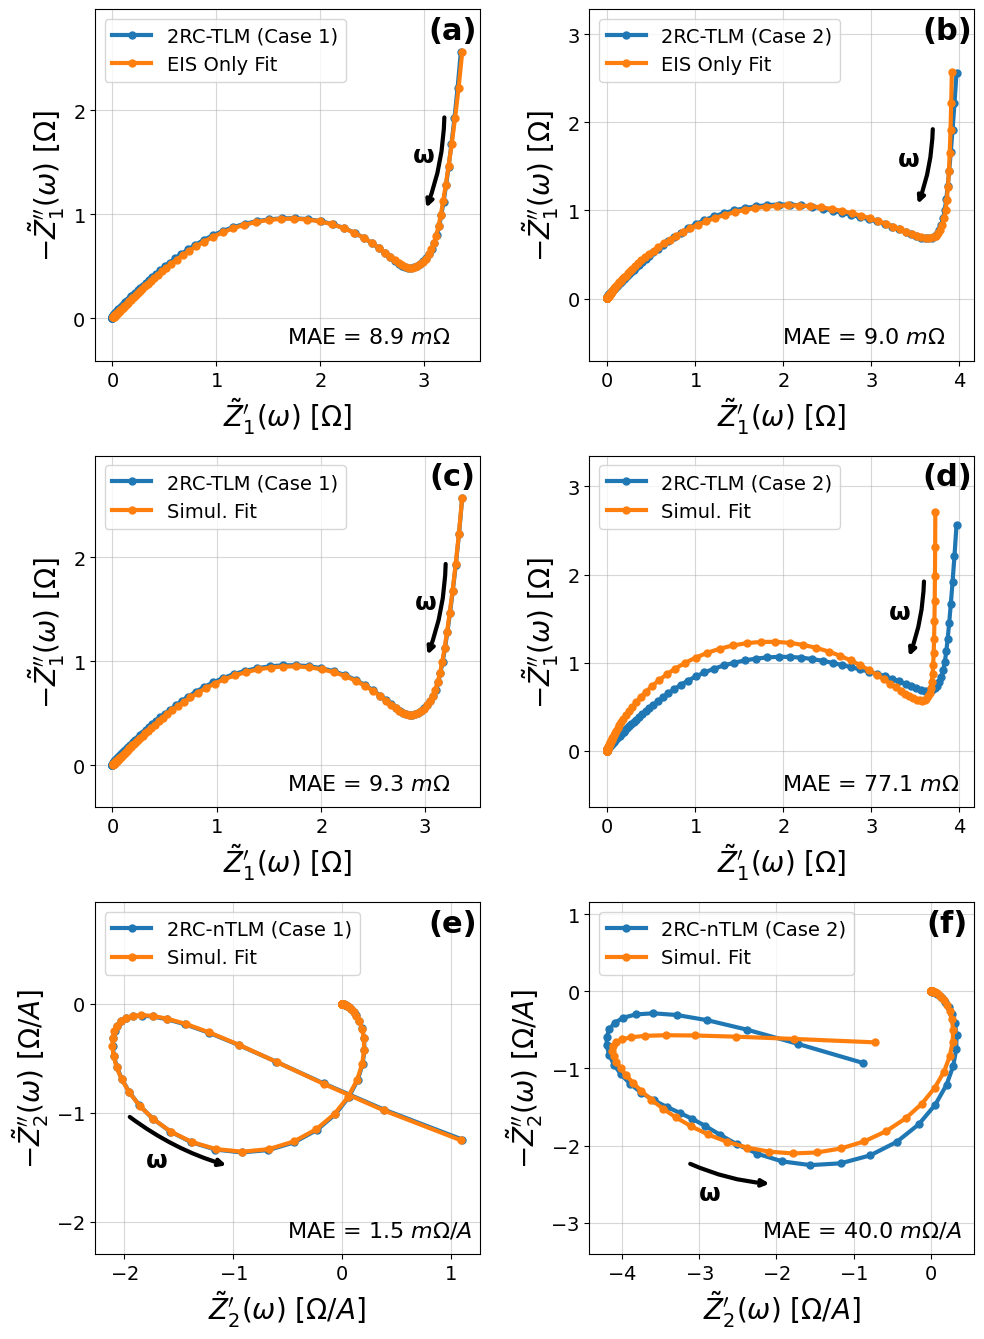

In [17]:
fig, ax = plt.subplots(3,2,figsize=(10,13.5))

## Case 1:

## EIS fitting
circ_str_1 = 'TDS0'
Rpore = 6;Rct = 0.6*2;Cdl = 0.72;Aw = 2;tau = 400
initial_guess = [Rpore, Rct, Cdl, Aw, tau]

## Perform EIS fitting 
eis_circuit_case1 = CustomCircuit(circ_str_1, initial_guess=initial_guess)
eis_circuit_case1.fit(f,Z_2RC_case1[0])
Z1_fit_case1 = eis_circuit_case1.predict(f)

## Generate the plot to compare fit with model
plot_first(ax[0,0],Z_2RC_case1[0], fmt='-o',lw=3,ms =5,alpha=1,label = '2RC-TLM (Case 1)')
plot_first(ax[0,0],Z1_fit_case1, fmt='-o',lw=3,ms =5,alpha=1,label = 'EIS Only Fit')
ax[0,0].legend(fontsize=14)

# ax[0,0].text(0.55, 0.13, f'R$^2$ = {R2(Z_2RC_case1[0], Z1_fit_case1):.4f}', fontsize=16, transform=ax[0,0].transAxes)
ax[0,0].text(0.5, 0.05, f'MAE = {1000*mae(Z_2RC_case1[0], Z1_fit_case1):.1f} $m\Omega$', fontsize=16, transform=ax[0,0].transAxes)

## Simultaneous fitting

circ_str_1 = 'TDS0'
circ_str_2 = 'TDSn0'

Rpore = 6;Rct = 0.6*2;Cdl = 0.72;Aw = 2;tau = 400
k = -1;eb = 0.1
initial_guess = [Rpore, Rct, Cdl, Aw, tau, k, eb]

simul_circuit_case1 = EISandNLEIS(circ_str_1,circ_str_2, initial_guess=initial_guess)
simul_circuit_case1.fit(f,Z_2RC_case1[0],Z_2RC_case1[1], max_f = np.inf)
Z1_simul_case1, Z2_simul_case1 = simul_circuit_case1.predict(f, max_f = np.inf)

plot_first(ax[1,0],Z_2RC_case1[0], fmt='-o',lw=3,ms =5,label = '2RC-TLM (Case 1)')
plot_first(ax[1,0],Z1_simul_case1, fmt='-o',lw=3,ms =5,label = 'Simul. Fit')
ax[1,0].legend(fontsize=14)
# ax[1,0].text(0.55, 0.13, f'R$^2$ = {R2(Z_2RC_case1[0], Z1_simul_case1):.4f}', fontsize=16, transform=ax[1,0].transAxes)
ax[1,0].text(0.5, 0.05, f'MAE = {1000*mae(Z_2RC_case1[0], Z1_simul_case1):.1f} $m\Omega$', fontsize=16, transform=ax[1,0].transAxes)

plot_second(ax[2,0],Z_2RC_case1[1], fmt='-o',lw=3,ms = 5,label = '2RC-nTLM (Case 1)')
plot_second(ax[2,0], Z2_simul_case1, fmt='-o',lw=3,ms = 5,label = 'Simul. Fit')
ax[2,0].legend(fontsize=14, loc = 'upper left')
# ax[2,0].text(0.55, 0.13, f'R$^2$ = {R2(Z_2RC_case1[1], Z2_simul_case1):.4f}', fontsize=16, transform=ax[2,0].transAxes)
ax[2,0].text(0.5, 0.05, f'MAE = {1000*mae(Z_2RC_case1[1], Z2_simul_case1):.1f} $m\Omega / A$', fontsize=16, transform=ax[2,0].transAxes)

## Case 2:

## EIS fitting
circ_str_1 = 'RCSQ0'
Rpore = 6;Rct = 0.6*2;Cdl = 0.72;Aw = 2;tau = 400; Q = 1
initial_guess = [Rct, Cdl,Q, Aw, tau]

## Perform EIS fitting 
eis_circuit_case2 = CustomCircuit(circ_str_1, initial_guess=initial_guess)
eis_circuit_case2.fit(f,Z_2RC_case2[0])
Z1_fit_case2 = eis_circuit_case2.predict(f)

## Generate the plot to compare fit with model
plot_first(ax[0,1],Z_2RC_case2[0], fmt='-o',lw=3,ms =5,alpha=1,label = '2RC-TLM (Case 2)')
plot_first(ax[0,1],Z1_fit_case2, fmt='-o',lw=3,ms =5,alpha=1,label = 'EIS Only Fit')
ax[0,1].legend(fontsize=14)
# ax[0,1].text(0.55, 0.13, f'R$^2$ = {R2(Z_2RC_case2[0], Z1_fit_case2):.4f}', fontsize=16, transform=ax[0,1].transAxes)
ax[0,1].text(0.5, 0.05, f'MAE = {1000*mae(Z_2RC_case2[0], Z1_fit_case2):.1f} $m\Omega$', fontsize=16, transform=ax[0,1].transAxes)

## Simultaneous fitting

circ_str_1 = 'RCSQ0'
circ_str_2 = 'RCSQn0'

Rpore = 6;Rct = 0.6*2;Cdl = 0.72;Aw = 2;tau = 400
k = -1;eb = 0.1
initial_guess = [Rct, Cdl,Q, Aw, tau, k, eb]

simul_circuit_case2 = EISandNLEIS(circ_str_1,circ_str_2, initial_guess=initial_guess)
simul_circuit_case2.fit(f,Z_2RC_case2[0],Z_2RC_case2[1],max_f = np.inf)
Z1_simul_case2, Z2_simul_case2 = simul_circuit_case2.predict(f, max_f = np.inf)

plot_first(ax[1,1],Z_2RC_case2[0], fmt='-o',lw=3,ms =5,label = '2RC-TLM (Case 2)')
plot_first(ax[1,1],Z1_simul_case2, fmt='-o',lw=3,ms =5,label = 'Simul. Fit')
ax[1,1].legend(fontsize=14)
# ax[1,1].text(0.55, 0.13, f'R$^2$ = {R2(Z_2RC_case2[0], Z1_simul_case2):.4f}', fontsize=16, transform=ax[1,1].transAxes)
ax[1,1].text(0.5, 0.05, f'MAE = {1000*mae(Z_2RC_case2[0], Z1_simul_case2):.1f} $m\Omega$', fontsize=16, transform=ax[1,1].transAxes)

plot_second(ax[2,1],Z_2RC_case2[1], fmt='-o',lw=3,ms = 5,label = '2RC-nTLM (Case 2)')
plot_second(ax[2,1], Z2_simul_case2, fmt='-o',lw=3,ms = 5,label = 'Simul. Fit')
ax[2,1].legend(fontsize=14, loc = 'upper left')
# ax[2,1].text(0.55, 0.13, f'R$^2$ = {R2(Z_2RC_case2[1], Z2_simul_case2):.4f}', fontsize=16, transform=ax[2,1].transAxes)
ax[2,1].text(0.45, 0.05, f'MAE = {1000*mae(Z_2RC_case2[1], Z2_simul_case2):.1f} $m\Omega / A$', fontsize=16, transform=ax[2,1].transAxes)

for idx, axi in enumerate(ax.flat):    
    axi.text(0.93, 0.94, f'({string.ascii_lowercase[idx]})',horizontalalignment='center',verticalalignment='center', transform=axi.transAxes, size=22, weight='bold')
arrow(ax[0,0], 3, 1, 3.2, 2, 2.9, 1.5, connectionstyle="arc3,rad=-.1")
arrow(ax[0,1], 3.5, 1, 3.7, 2, 3.3, 1.5, connectionstyle="arc3,rad=-.1")
arrow(ax[1,0], 3, 1, 3.2, 2, 2.9, 1.5, connectionstyle="arc3,rad=-.1")
arrow(ax[1,1], 3.4, 1, 3.6, 2, 3.2, 1.5, connectionstyle="arc3,rad=-.1")


arrow(ax[2,0], -1, -1.5, -2, -1, -1.8, -1.5, connectionstyle="arc3,rad=.1")
arrow(ax[2,1], -2, -2.5, -3.2, -2.2, -3, -2.7, connectionstyle="arc3,rad=.1")

plt.tight_layout()
plt.show()

In [18]:
fig.savefig('figures/Figure6.png',dpi=300,bbox_inches='tight')

In [19]:
print('Case 1: Modeled parameters')
header=['Rpore','Rct','Cdl','Aw','τ','Rs','Cs','κ','eb','es']

Rpore = 6;Rct = 0.6;Cdl = 2*0.72;Aw = 2;tau = 400
Rs = 0.6;Cs = 2*0.72;k = -1;eb = 0.1;es = 0.1
p = [Rpore, Rct, Cdl, Aw, tau, Rs, Cs, k, eb, es]
print(tabulate([p],headers=header))

print('')
print('Case 1: EIS Fitting Results')
header=['Rpore','Rct','Cdl','Aw','τ']
print(tabulate([eis_circuit_case1.parameters_],headers=header))

print('')
print('Case 1: Simultaneous Fitting Results')
header=['Rpore','Rct','Cdl','Aw','τ', 'κ','eb']
print(tabulate([simul_circuit_case1.parameters_],headers=header))

Case 1: Modeled parameters
  Rpore    Rct    Cdl    Aw    τ    Rs    Cs    κ    eb    es
-------  -----  -----  ----  ---  ----  ----  ---  ----  ----
      6    0.6   1.44     2  400   0.6  1.44   -1   0.1   0.1

Case 1: EIS Fitting Results
  Rpore      Rct       Cdl       Aw        τ
-------  -------  --------  -------  -------
6.28507  1.13328  0.791753  1.82338  372.013

Case 1: Simultaneous Fitting Results
  Rpore      Rct       Cdl       Aw        τ          κ        eb
-------  -------  --------  -------  -------  ---------  --------
6.00981  1.16753  0.742044  1.95467  394.569  -0.983763  0.052255


In [20]:
print('Case 2: Modeled parameters')
header=['Rpore','Rct','Cdl','Aw','τ','Rs','Cs','κ','eb','es']

Rpore = 6;Rct = .6*2;Cdl = .72;Aw = 2;tau = 400
Rs = 0.6;Cs = 7.2;k = -1;eb = 0.1;es = 0.1
p = [Rpore, Rct, Cdl, Aw, tau, Rs, Cs, k, eb, es]
print(tabulate([p],headers=header))

print('')
print('Case 2: EIS Fitting Results')
header=['Rct','Cdl', 'Qdl','A','τ']
print(tabulate([eis_circuit_case2.parameters_],headers=header))

print('')
print('Case 2: Simultaneous Fitting Results')
header=['Rct','Cdl', 'Qdl','A','τ', 'κ','eb']
print(tabulate([simul_circuit_case2.parameters_],headers=header))

Case 2: Modeled parameters
  Rpore    Rct    Cdl    Aw    τ    Rs    Cs    κ    eb    es
-------  -----  -----  ----  ---  ----  ----  ---  ----  ----
      6    1.2   0.72     2  400   0.6   7.2   -1   0.1   0.1

Case 2: EIS Fitting Results
    Rct       Cdl      Qdl         A        τ
-------  --------  -------  --------  -------
4.04545  0.219868  0.60462  0.504962  92.0477

Case 2: Simultaneous Fitting Results
    Rct       Cdl       Qdl        A        τ         κ         eb
-------  --------  --------  -------  -------  --------  ---------
3.58244  0.176979  0.759771  1.13254  200.142  -1.08595  0.0189872
